# ImageNet Classification with Deep Convolution Neural Network

CNN의 시작 모델인 AlexNet에 대한 구현 코드이다

데이터셋은 Cifar 10 을 사용해 성능을 확인하겠다.

### 데이터 셋

모델 성능 확인을 위한 데이터 셋으로 Cifar 10을 사용하였다

Training data 50000개 / label 10개로 각 5000개 씩, Test data 10000개 / label 10개로 각 1000개 씩으로 구성된다

In [ ]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print ("Training data:")
print ("Number of examples: ", X_train.shape[0])
print ("Number of channels:",X_train.shape[3])
print ("Image size:", X_train.shape[1], X_train.shape[2])
print
print ("Test data:")
print ("Number of examples:", X_test.shape[0])
print ("Number of channels:", X_test.shape[3])
print ("Image size:", X_test.shape[1], X_test.shape[2])

170498071/170498071 [==============================] - 13s 0us/step
Training data:
Number of examples:  50000
Number of channels: 3
Image size: 32 32
Test data:
Number of examples: 10000
Number of channels: 3
Image size: 32 32


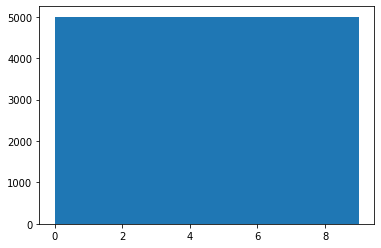

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(y_train)

plt.show()

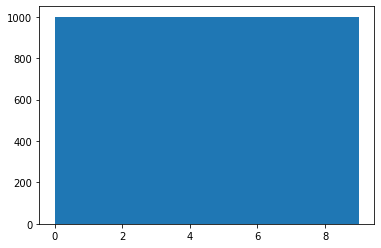

In [ ]:
import numpy as np

plt.hist(y_test)

plt.show()

[6]


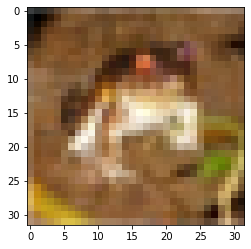

[9]


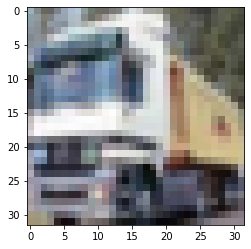

[9]


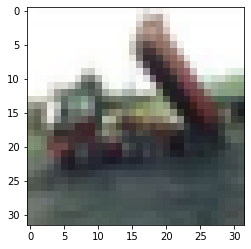

[4]


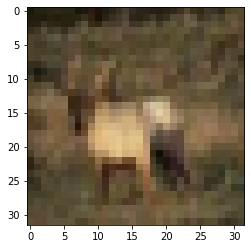

[1]


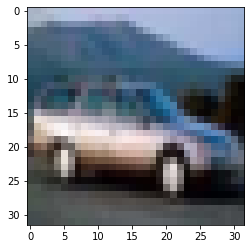

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    print(y_train[i])
    plt.imshow(X_train[i])
    plt.show();

### 데이터 전처리

데이터 전처리를 위해 이미지의 평균을 전체 이미지 픽셀에서 뺀다
= Zero Center

- Zero Center를 하는 이유 : 픽셀의 값이 모두 같은 부호(양수)는 학습에 좋지 않다고 한다. Sigmoid보다 tanh가 -1~1까지의 범위이기에 더 좋은 것과 비슷한 원리인 듯
- Zero Center를 위해 subtract mean을 해줄 때 전체 이미지에 대해서 mean을 구할 수도, Channel별로 mean을 구할 수도 있다. 큰 차이는 없다고 한다

In [ ]:
def preprocess(x):
    mean = x.sum() / (x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]) #전체 이미지 픽셀에 대한 mean 값을 만들었다
    zerocentered_x = x - mean

    return zerocentered_x

In [ ]:
normalized_X_train = preprocess(X_train)
normalized_X_test = preprocess(X_test)

### 모델링

AlexNet은 5개의 ConvNet, 3개의 FC로 이루어져 있다

32 X 32 이미지로 이미지 사이즈가 크지 않다는 것을 고려해 filter size와 stride를 조정, 구현하겠다. (layer 깊이는 동일하게)

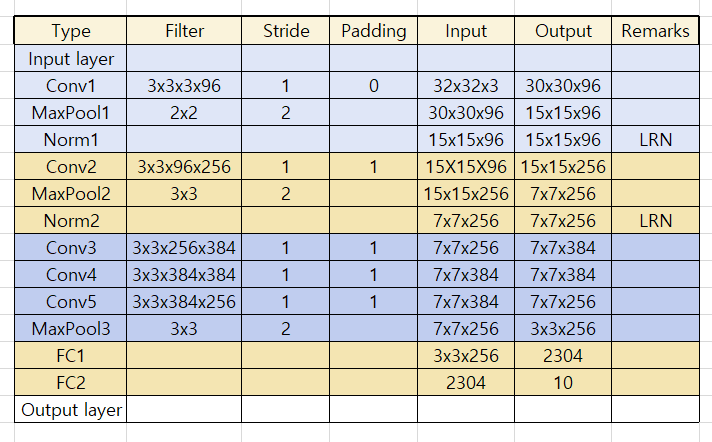

GPU는 병렬 처리 하지 않았다고 가정하고 구현하겠다

### Forward Propagation

### Conv & Maxpool 함수 설명

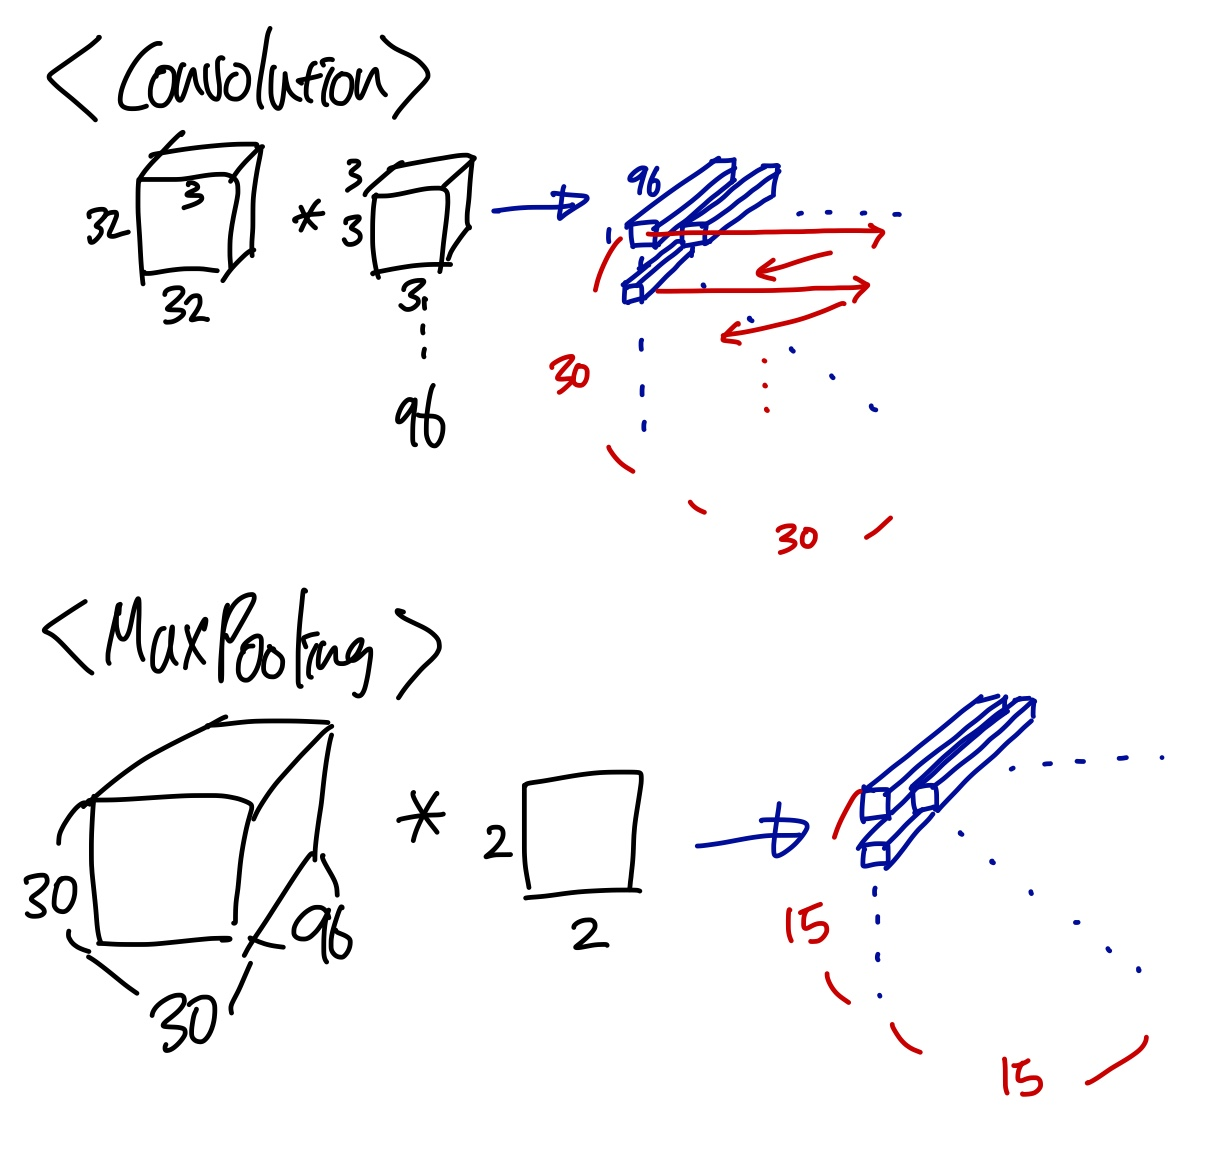

In [ ]:
def Conv(Filter,b,Stride,padding_size,x):
    padding_x = zero_padding(x,padding_size)

    Filter_size = Filter.shape[0]
    W = padding_x.shape[0]
    H = padding_x.shape[1]
    Channel = Filter.shape[3]
    i = 0
    j = 0
    out_Z = []
    out_A = []

    out_size = int((x.shape[0] + 2 * padding_size - Filter_size) / Stride + 1)

    while i < W:
        while j < H:
            for k in range(Channel):
                if (W - i < Filter_size) or (H - j < Filter_size):
                    break;
                conv_value = np.sum(padding_x[i:i+Filter_size,j:j+Filter_size,:] * Filter[:,:,:,k])
                acti_conv_value = Relu(conv_value)
                out_Z.append(acti_conv_value)
                out_A.append(conv_value)
            j = j + Stride
        j = 0
        i = i + Stride

    Output_Z = np.transpose(np.array(out_Z).reshape(-1,out_size,out_size),(2,1,0)) + b
    Output_A = np.transpose(np.array(out_A).reshape(-1,out_size,out_size),(2,1,0)) + b

    return Output_Z, Output_A

def Conv_derivative_k(Filter,b,Stride,padding_size,x):
    padding_x = zero_padding(x,padding_size)

    Filter_size = Filter.shape[0]
    W = padding_x.shape[0]
    H = padding_x.shape[1]

    Filter = Filter.reshape(Filter_size,Filter_size,-1)
    Channel = Filter.shape[2]
    i = 0
    j = 0
    out_Z = []
    out_A = []

    out_size = int((x.shape[0] + 2 * padding_size - Filter_size) / Stride + 1)

    while i < W:
        while j < H:
            for k in range(Channel):
                if (W - i < Filter_size) or (H - j < Filter_size):
                    break;
                conv_value = np.sum(padding_x[i:i+Filter_size,j:j+Filter_size,:] * Filter[:,:,k])
                acti_conv_value = Relu(conv_value)
                out_Z.append(acti_conv_value)
                out_A.append(conv_value)
            j = j + Stride
        j = 0
        i = i + Stride

    Output_Z = np.transpose(np.array(out_Z).reshape(-1,out_size,out_size),(2,1,0)) + b
    Output_A = np.transpose(np.array(out_A).reshape(-1,out_size,out_size),(2,1,0)) + b

    return Output_Z, Output_A

def Conv_derivative_x(Filter,b,Stride,padding_size,x):
    padding_x = zero_padding(x,padding_size)

    Filter_size = Filter.shape[0]
    W = padding_x.shape[0]
    H = padding_x.shape[1]

    Filter = Filter.reshape(Filter_size,Filter_size,1,1)
    Channel = Filter.shape[2]
    i = 0
    j = 0
    out_Z = []
    out_A = []

    out_size = int((x.shape[0] + 2 * padding_size - Filter_size) / Stride + 1)

    while i < W:
        while j < H:
            for k in range(Channel):
                if (W - i < Filter_size) or (H - j < Filter_size):
                    break;
                conv_value = np.sum(padding_x[i:i+Filter_size,j:j+Filter_size,:] * Filter[:,:,k])
                acti_conv_value = Relu(conv_value)
                out_Z.append(acti_conv_value)
                out_A.append(conv_value)
            j = j + Stride
        j = 0
        i = i + Stride

    Output_Z = np.transpose(np.array(out_Z).reshape(-1,out_size,out_size),(2,1,0)) + b
    Output_A = np.transpose(np.array(out_A).reshape(-1,out_size,out_size),(2,1,0)) + b

    return Output_Z, Output_A

In [ ]:
def MaxPool(Filter,Stride,padding_size,x):
    Filter_size = Filter
    W = x.shape[0]
    H = x.shape[1]
    Channel = x.shape[2]
    i = 0
    j = 0
    out = []

    out_size = int((x.shape[0] + 2 * padding_size - Filter_size) / Stride + 1)

    maxpool_binary = []

    while i < W:
        while j < H:
            for k in range(Channel):
                if (W - i < Filter_size) or (H - j < Filter_size):
                    break;
                conv_value = max(map(max,x[i:i+Filter_size,j:j+Filter_size,k]))

                overlap = 0
                for m in range(i,i+Filter_size): #Backpropagate를 위해 어떤 값을 maxpool해 가져왔는지 index값을 저장하는 과정
                    for n in range(j,j+Filter_size):
                        if conv_value == x[m,n,k]:
                            overlap = overlap + 1

                            if overlap > 1: #한 필터 안에 두개 이상의 max 값이 중복이 되는 경우 하나의 값만 가져올 수 있도록 하였다.
                                break;
                            maxpool_binary.append([m,n,k])
                    if overlap > 1:
                        break;

                out.append(conv_value)
            j = j + Stride
        j = 0
        i = i + Stride

    Output = np.transpose(np.array(out).reshape(-1,out_size,out_size),(2,1,0))

    return Output, maxpool_binary

### Local Response Normalization

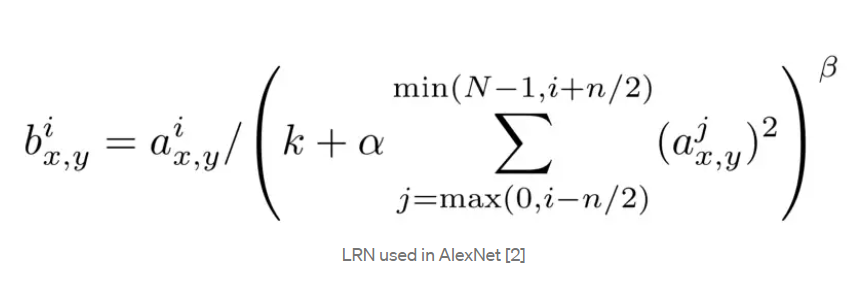

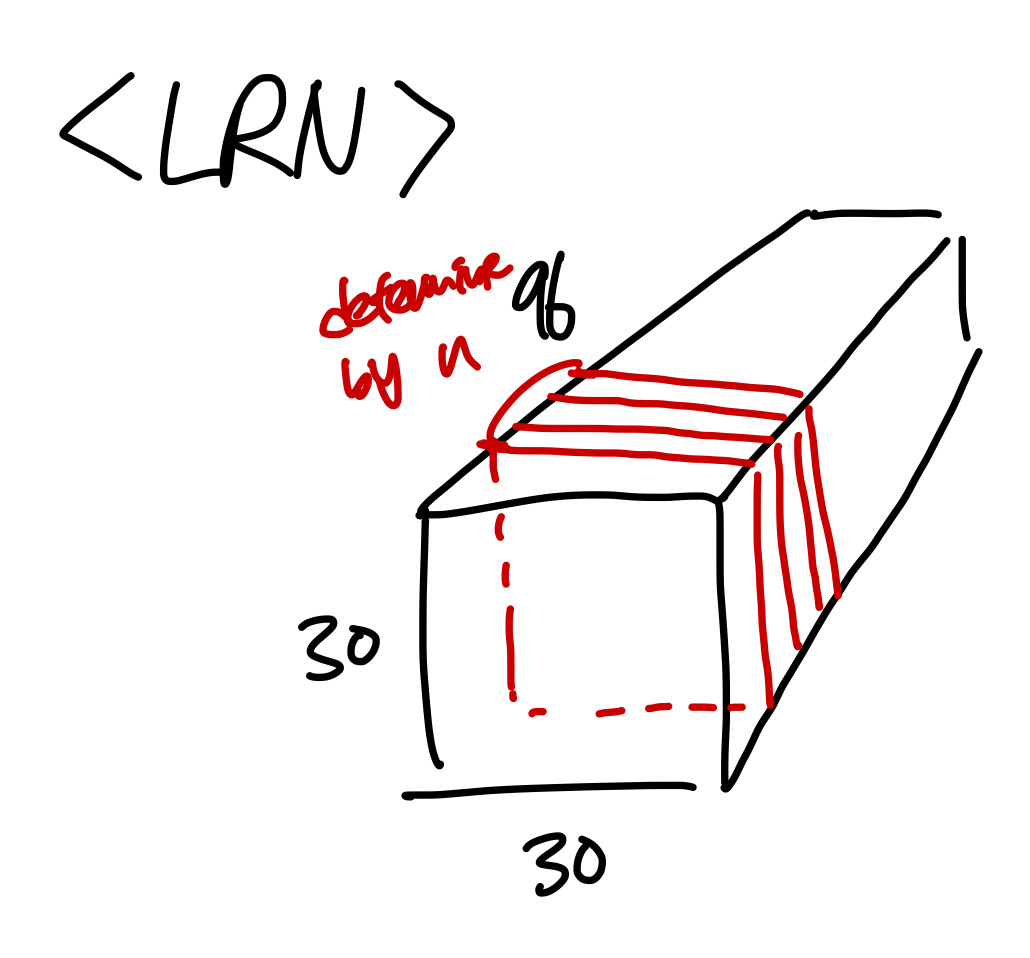

In [ ]:
def LRN(activ_x,k,alpha,n,beta):
    N = activ_x.shape[2]
    W = activ_x.shape[0]
    H = activ_x.shape[1]

    LRN_out = []
    LRN_A = []


    for i in range(N):
        around_x = np.zeros((W,H))
        for j in range(max(0,i-int(n/2)),min(N-1,i+int(n/2))):
            around_x = around_x + np.power(activ_x[:,:,j],2) #Sigma
        A = k + alpha * (around_x)
        LRN_activ_x = activ_x[:,:,i] / A ** beta
        LRN_out.append(LRN_activ_x)
        LRN_A.append(A)

    return np.array(LRN_out).reshape(W,H,N), np.array(LRN_A).reshape(W,H,N)

In [ ]:
activ_x = np.random.randn(15,15,96)
k = 2
alpha = 0.0004
n = 5
beta = 0.75

out, A = LRN(activ_x,k,alpha,n,beta)
print(out.shape)
print(A.shape)

(15, 15, 96)
(15, 15, 96)


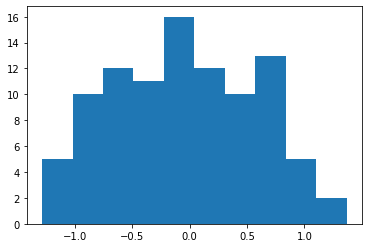

In [ ]:
import matplotlib.pyplot as plt

a,_ = LRN(activ_x,k,alpha,n,beta)
plt.hist(a[1,1,:])

plt.show();

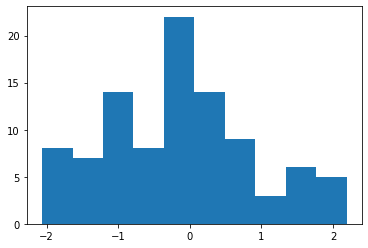

In [ ]:
plt.hist(activ_x[1,1,:])

plt.show();

LRN 결과 나름 정규화가 된 모습을 확인할 수 있다

### Extra Functions

In [ ]:
def Relu(x):

    return np.maximum(0,x)

def zero_padding(x,size):

    W = x.shape[0]
    H = x.shape[1]

    x = x.reshape(W,H,-1)

    C = x.shape[2]

    padded_x = np.zeros((W + 2 * size,H + 2 * size,C))

    for i in range(size, W+size):
        for j in range(size, H+size):
            padded_x[i,j] = padded_x[i,j] + x[i - size,j - size]

    return padded_x

def Flatten_layer(x):
    flatten_x = x.flatten().reshape(1,-1)

    return flatten_x

def Softmax(x):
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x

    return y

def FC_layer(x,W,b,activ_f):
    Z = np.dot(x,W) + b

    if activ_f == 'softmax':
        A = Softmax(Z)
    elif activ_f == 'relu':
        A = Relu(Z)

    return Z, A

##### Buidling Alexnet - Foward Propagation

In [ ]:
parameters = {}

def initialize_parameters():
    parameters['Filter_Conv1'] = np.random.normal(loc=0.0, scale=0.01, size = (3,3,3,96))
    parameters['Filter_Conv2'] = np.random.normal(loc=0.0, scale=0.01, size = (3,3,96,256))
    parameters['Filter_Conv3'] = np.random.normal(loc=0.0, scale=0.01, size = (3,3,256,384))
    parameters['Filter_Conv4'] = np.random.normal(loc=0.0, scale=0.01, size = (3,3,384,384))
    parameters['Filter_Conv5'] = np.random.normal(loc=0.0, scale=0.01, size = (3,3,384,256))

    parameters['b_Conv1'] = 0
    parameters['b_Conv2'] = 1
    parameters['b_Conv3'] = 0
    parameters['b_Conv4'] = 1
    parameters['b_Conv5'] = 1

    parameters['W1'] = np.random.normal(loc=0.0, scale=0.01, size = (2304,2304))
    parameters['b1'] = 1
    parameters['W2'] = np.random.normal(loc=0.0, scale=0.01, size = (2304,10))
    parameters['b2'] = 1

def forward_propagation(x):
    Conv1_Z,Conv1_A = Conv(parameters['Filter_Conv1'], parameters['b_Conv1'],1,0, x)
    LRN1,LRN1_A = LRN(Conv1_Z,2,0.0004,5,0.75)
    MaxPool1, MaxPool1_bin = MaxPool(2,2,0,LRN1)


    Conv2_Z, Conv2_A = Conv(parameters['Filter_Conv2'], parameters['b_Conv2'],1,1,MaxPool1)
    LRN2,LRN2_A = LRN(Conv2_Z,2,0.0004,5,0.75)
    MaxPool2, MaxPool2_bin = MaxPool(3,2,0,LRN2)


    Conv3_Z, Conv3_A = Conv(parameters['Filter_Conv3'],parameters['b_Conv3'],1,1,MaxPool2)
    Conv4_Z,Conv4_A = Conv(parameters['Filter_Conv4'],parameters['b_Conv4'],1,1,Conv3_Z)
    Conv5_Z, Conv5_A = Conv(parameters['Filter_Conv5'],parameters['b_Conv5'],1,1,Conv4_Z)
    MaxPool3, MaxPool3_bin = MaxPool(3,2,0,Conv5_Z)


    Flatten_input = Flatten_layer(MaxPool3)
    FC1_Z, FC1_A = FC_layer(Flatten_input,parameters['W1'] ,parameters['b1'],'relu')
    FC2_Z, FC2_A = FC_layer(FC1_A,parameters['W2'],parameters['b2'],'softmax')

    store = {}

    store['A2'] = FC2_A
    store['Z2'] = FC2_Z
    store['W2'] = parameters['W2']
    store['b2'] = parameters['b2']

    store['A1'] = FC1_A
    store['Z1'] = FC1_Z
    store['W1'] = parameters['W1']
    store['b1'] = parameters['b1']

    store['A0'] = Flatten_input

    store['A0_prev'] = MaxPool3.shape

    store['Filter_Conv5'] = parameters['Filter_Conv5']
    store['Filter_Conv4'] = parameters['Filter_Conv4']
    store['Filter_Conv3'] = parameters['Filter_Conv3']
    store['Filter_Conv2'] = parameters['Filter_Conv2']
    store['Filter_Conv1'] = parameters['Filter_Conv1']

    store['b_Conv5'] =  parameters['b_Conv5']
    store['b_Conv4'] = parameters['b_Conv4']
    store['b_Conv3'] = parameters['b_Conv3']
    store['b_Conv2'] = parameters['b_Conv2']
    store['b_Conv1'] = parameters['b_Conv1']

    store['MaxPool3_bin'] = MaxPool3_bin
    store['MaxPool2_bin'] = MaxPool2_bin
    store['MaxPool1_bin'] = MaxPool1_bin

    store['MaxPool3'] = MaxPool3
    store['MaxPool2'] = MaxPool2
    store['MaxPool1'] = MaxPool1

    store['Conv5_Z'] = Conv5_Z
    store['Conv4_Z'] = Conv4_Z
    store['Conv3_Z'] = Conv3_Z
    store['Conv2_Z'] = Conv2_Z
    store['Conv1_Z'] = Conv1_Z

    store['Conv5_A'] = Conv5_A
    store['Conv4_A'] = Conv4_A
    store['Conv3_A'] = Conv3_A
    store['Conv2_A'] = Conv2_A
    store['Conv1_A'] = Conv1_A

    store['LRN1'] = LRN1
    store['LRN1_A'] = LRN1_A
    store['LRN2'] = LRN2
    store['LRN2_A'] = LRN2_A

    return FC2_A, store

In [ ]:
print(normalized_X_train[0].shape)

initialize_parameters()
y , store = forward_propagation(normalized_X_train[0])

print(y)
print(store)

(32, 32, 3)
[[0.06659656 0.09244394 0.07318262 0.11434679 0.10495189 0.09114378
  0.11729554 0.084305   0.12585391 0.12987997]]
{'A2': array([[0.06659656, 0.09244394, 0.07318262, 0.11434679, 0.10495189,
        0.09114378, 0.11729554, 0.084305  , 0.12585391, 0.12987997]]), 'Z2': array([[0.92457036, 1.25251987, 1.01887538, 1.46515332, 1.37941949,
        1.23835577, 1.49061422, 1.16035862, 1.56103926, 1.59252815]]), 'W2': array([[ 0.00698567,  0.00676482,  0.01150022, ...,  0.00638275,
         0.01060678, -0.01398892],
       [-0.00792552,  0.00216046,  0.00576303, ..., -0.00461684,
         0.00860893,  0.00884206],
       [-0.00293312, -0.00892169,  0.0192756 , ..., -0.00331578,
         0.01232087,  0.00278587],
       ...,
       [-0.02096114,  0.0025248 , -0.00688817, ..., -0.00252904,
         0.0117493 ,  0.01590615],
       [-0.01105374,  0.00487406,  0.00317303, ...,  0.00240758,
         0.03507911,  0.01118204],
       [-0.01280195, -0.00590182,  0.00444466, ...,  0.00749686

### Backward Propagation

In [ ]:
print(y_train.shape)
print(y_test.shape)

(50000, 1)
(10000, 1)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_onehot = to_categorical(y_train, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)

In [ ]:
print(y_train_onehot.shape)
print(y_test_onehot.shape)

(50000, 10)
(10000, 10)


In [ ]:
def CE_Loss(y,p):
    loss_val = -(np.sum(y * np.log10(p)))
    return loss_val

In [ ]:
import copy

def Relu_derivative(Z):
    dZ = Z > 0
    return dZ.astype(int)


def MaxPool_derivative(p,dp,p_locate):
    p_zeros = np.zeros(p.shape)
    p_locate_index = 0
    for i in range(dp.shape[0]):
        for j in range(dp.shape[1]):
            for k in range(dp.shape[2]):
                q = p_locate[p_locate_index][0]
                w = p_locate[p_locate_index][1]
                e = p_locate[p_locate_index][2]
                if p_zeros[q,w,e] == 0:
                    p_zeros[q,w,e] = dp[i,j,k]
                else :
                    p_zeros[q,w,e] = p_zeros[q,w,e] + dp[i,j,k]
                p_locate_index = p_locate_index + 1

    return p_zeros

def dConv_broadcast(dC,F):
    C = []
    for i in range(F.shape[2]):
        C.append(dC)

    return np.array(C).reshape(dC.shape[0],dC.shape[0],F.shape[2])



def rotate_180(m):
    N = len(m)
    ret = [[0] * N for _ in range(N)]

    for r in range(N):
        for c in range(N):
            ret[N-1-r][N-1-c] = m[r][c]
    return ret



def dConv_rotate(k):
    k_copy = copy.deepcopy(k)
    for i in range(k_copy.shape[3]):
        for j in range(k_copy.shape[2]):
            rot = rotate_180(k[:,:,j,i])
            k_copy[:,:,j,i] = rot

    return k_copy


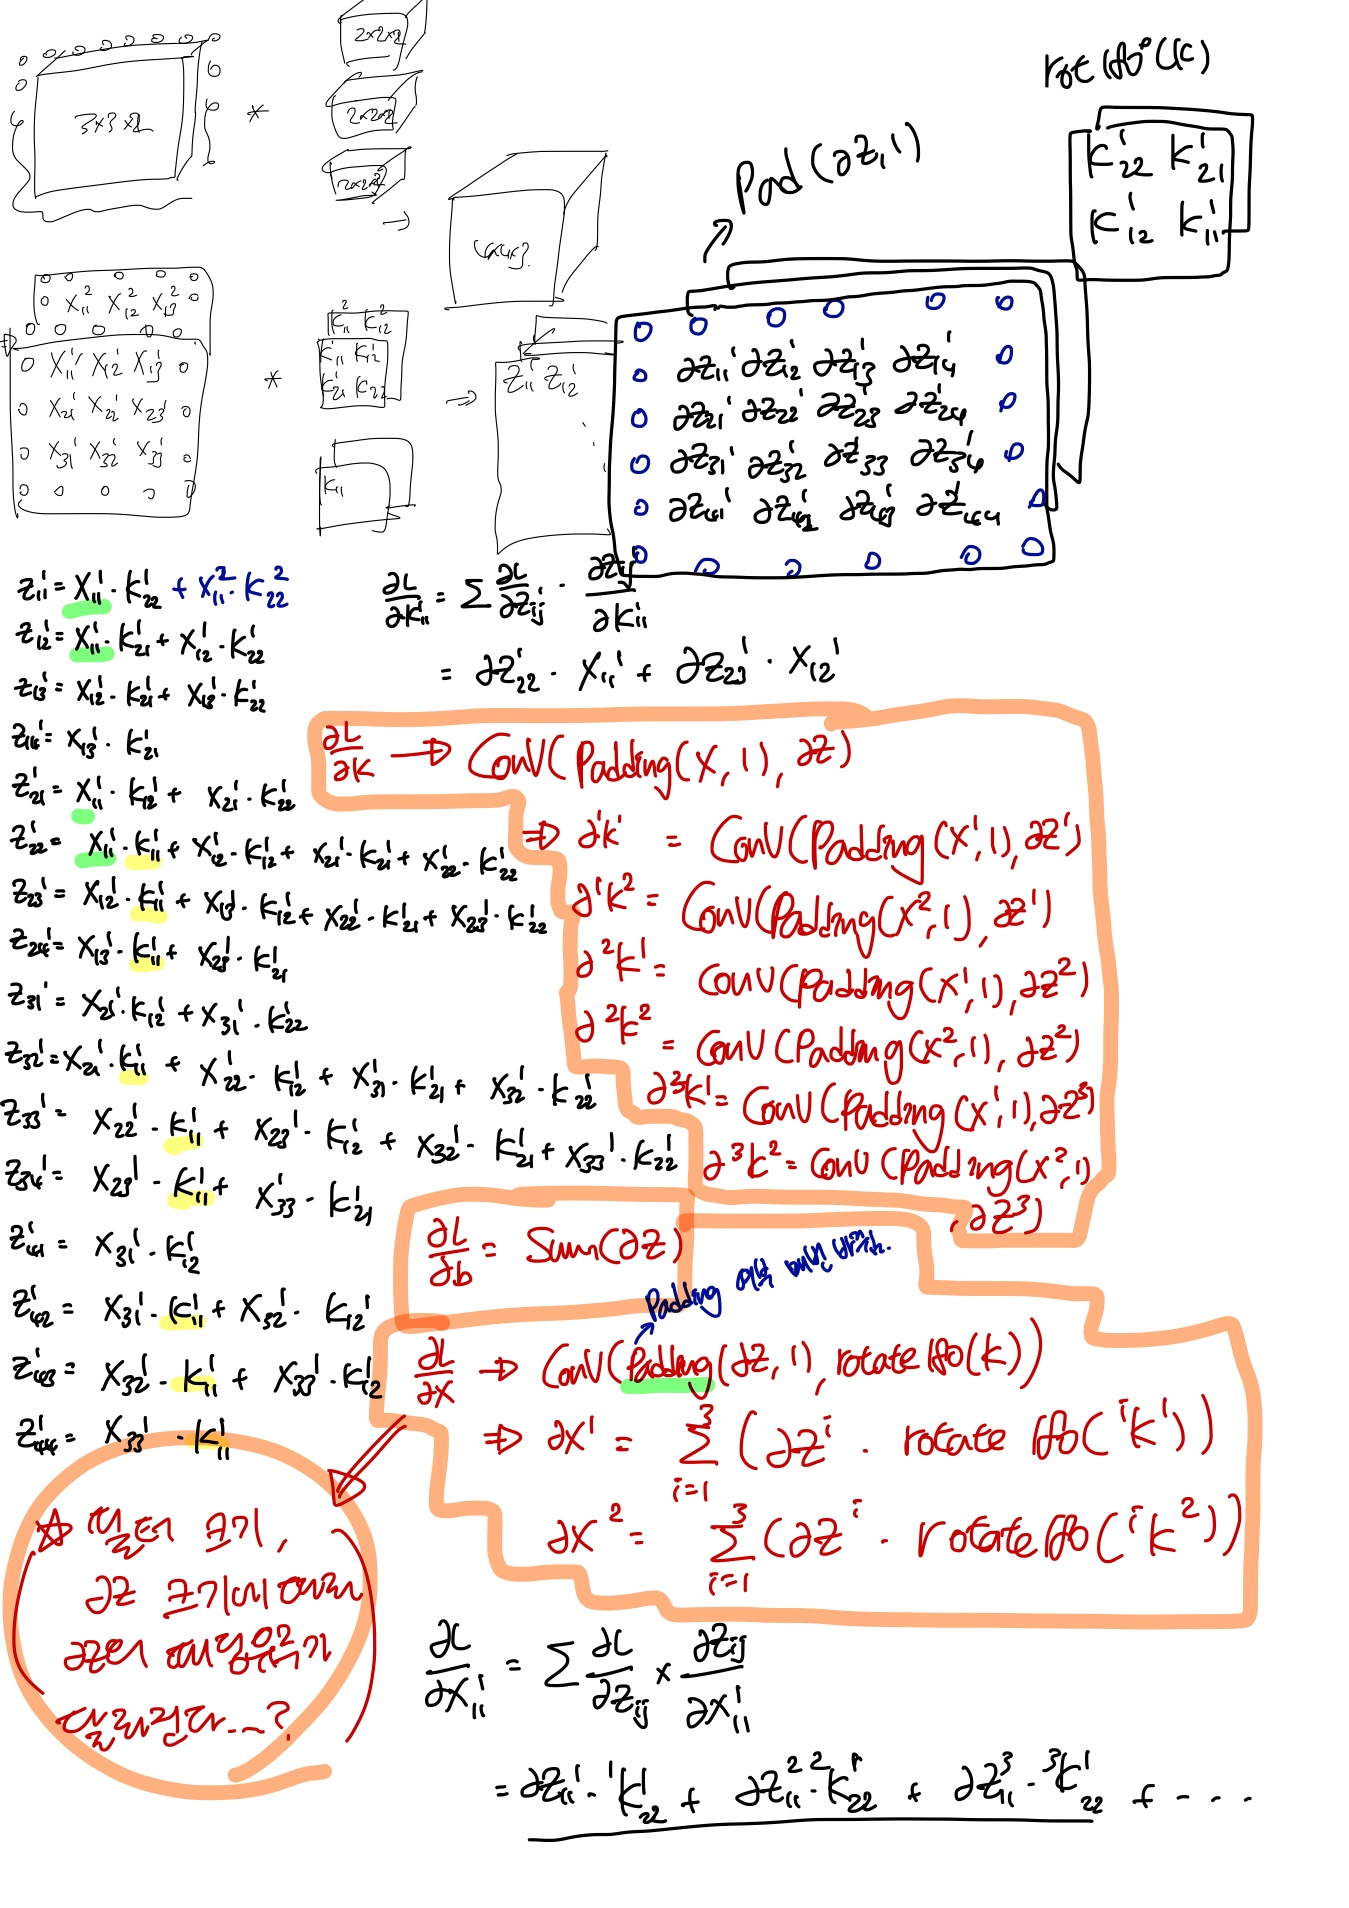

In [ ]:
def dConv5(dz,x,Filter):
    dk = []

    for i in range(dz.shape[2]):
        for j in range(x.shape[2]):
            out, _ = Conv_derivative_k(dz[:,:,i],0,1,1, x[:,:,j])
            dk.append(out)

    out_dk = np.array(dk).reshape(Filter.shape)
    out_db = np.sum(dz)

    dx = []

    Filter_rot180 = dConv_rotate(Filter)

    for i in range(Filter.shape[2]):
        dx_before_sum = 0
        for j in range(Filter.shape[3]):
            val,_ = Conv_derivative_x(Filter_rot180[:,:,i,j],0,1,1, dz[:,:,j])
            dx_before_sum = dx_before_sum + val
        dx.append(dx_before_sum)

    out_dx = np.array(dx).reshape(x.shape)

    return out_dk, out_db, out_dx

def dConv4(dz,x,Filter):
    dk = []

    for i in range(dz.shape[2]):
        for j in range(x.shape[2]):
            out, _ = Conv_derivative_k(dz[:,:,i],0,1,1, x[:,:,j])
            dk.append(out)

    out_dk = np.transpose(np.array(dk),(1,2,0,3)).reshape(Filter.shape)
    out_db = np.sum(dz)

    dx = []

    Filter_rot180 = dConv_rotate(Filter)

    for i in range(Filter.shape[2]):
        dx_before_sum = 0
        for j in range(Filter.shape[3]):
            val,_ = Conv_derivative_x(Filter_rot180[:,:,i,j],0,1,1, dz[:,:,j])
            dx_before_sum = dx_before_sum + val
        dx.append(dx_before_sum)

    out_dx = np.array(dx).reshape(x.shape)

    return out_dk, out_db, out_dx

def dConv3(dz,x,Filter):
    dk = []

    for i in range(dz.shape[2]):
        for j in range(x.shape[2]):
            out, _ = Conv_derivative_k(dz[:,:,i],0,1,1, x[:,:,j])
            dk.append(out)

    out_dk = np.array(dk).reshape(Filter.shape)
    out_db = np.sum(dz)

    dx = []

    Filter_rot180 = dConv_rotate(Filter)

    for i in range(Filter.shape[2]):
        dx_before_sum = 0
        for j in range(Filter.shape[3]):
            val,_ = Conv_derivative_x(Filter_rot180[:,:,i,j],0,1,1, dz[:,:,j])
            dx_before_sum = dx_before_sum + val
        dx.append(dx_before_sum)

    out_dx = np.array(dx).reshape(x.shape)

    return out_dk, out_db, out_dx

def dConv2(dz,x,Filter):
    dk = []

    for i in range(dz.shape[2]):
        for j in range(x.shape[2]):
            out, _ = Conv_derivative_k(dz[:,:,i],0,1,1, x[:,:,j])
            dk.append(out)

    out_dk = np.array(dk).reshape(Filter.shape)
    out_db = np.sum(dz)

    dx = []

    Filter_rot180 = dConv_rotate(Filter)

    for i in range(Filter.shape[2]):
        dx_before_sum = 0
        for j in range(Filter.shape[3]):
            val,_ = Conv_derivative_x(Filter_rot180[:,:,i,j],0,1,1, dz[:,:,j])
            dx_before_sum = dx_before_sum + val
        dx.append(dx_before_sum)

    out_dx = np.array(dx).reshape(x.shape)

    return out_dk, out_db, out_dx

def dConv1(dz,x,Filter):
    dk = []

    for i in range(dz.shape[2]):
        for j in range(x.shape[2]):
            out, _ = Conv_derivative_k(dz[:,:,i],0,1,0, x[:,:,j])
            dk.append(out)

    out_dk = np.array(dk).reshape(Filter.shape)
    out_db = np.sum(dz)

    dx = []

    Filter_rot180 = dConv_rotate(Filter)

    for i in range(Filter.shape[2]):
        dx_before_sum = 0
        for j in range(Filter.shape[3]):
            val,_ = Conv_derivative_x(Filter_rot180[:,:,i,j],0,1,2, dz[:,:,j])
            dx_before_sum = dx_before_sum + val
        dx.append(dx_before_sum)

    out_dx = np.array(dx).reshape(x.shape)

    return out_dk, out_db, out_dx

### LRN derivative

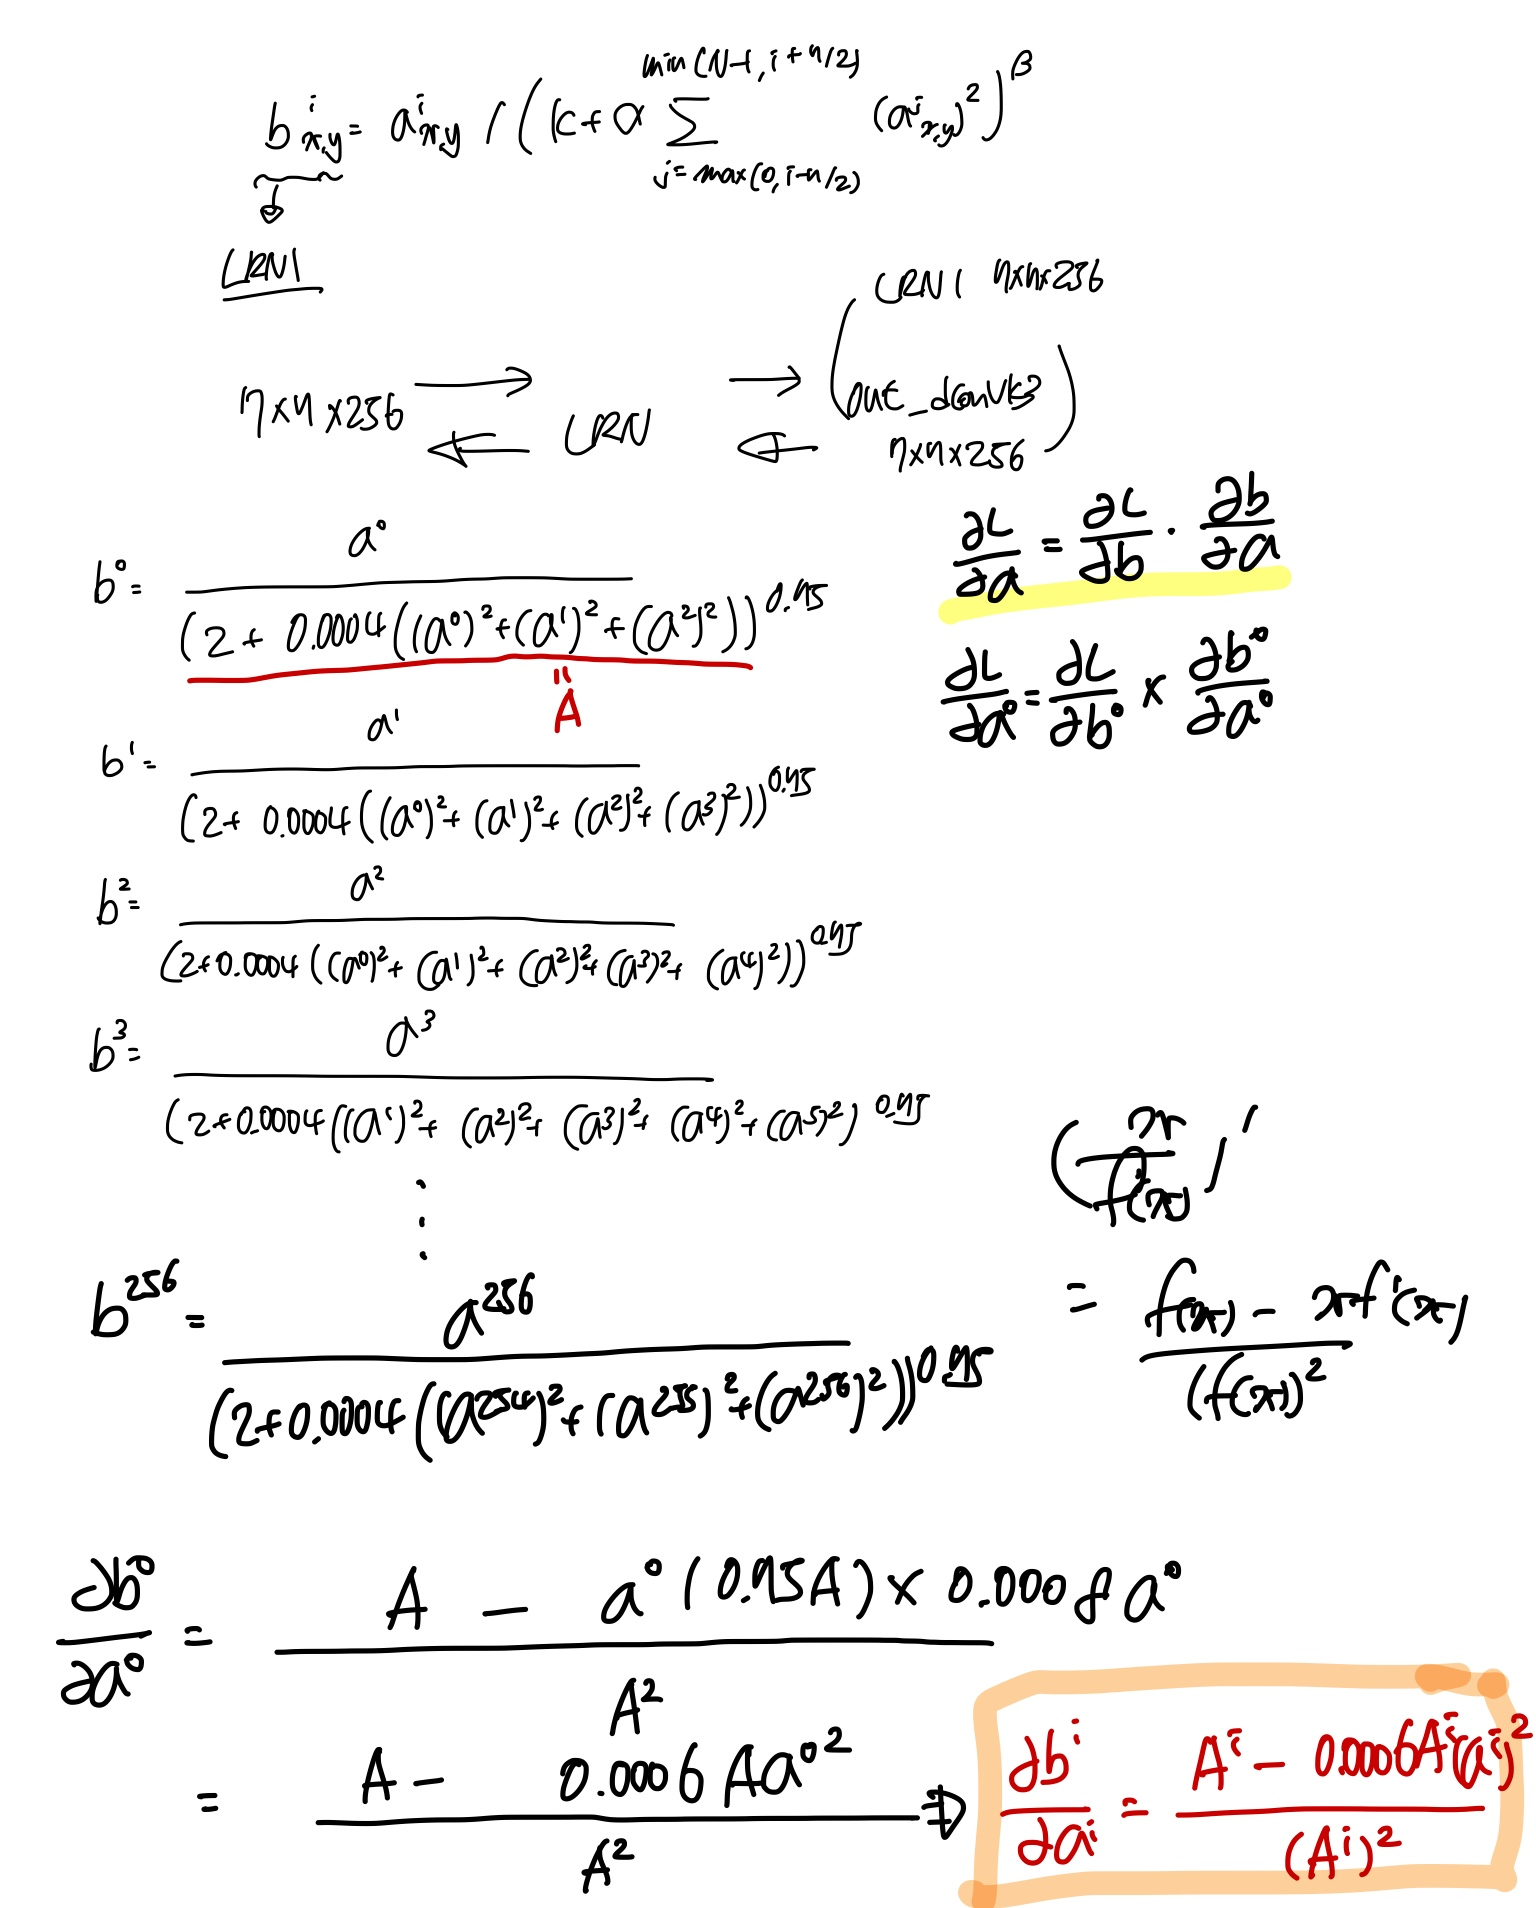

In [ ]:
def dLRN(db,lrn,lrn_a):
    da = []
    for i in range(lrn.shape[2]):
        out = (lrn_a[:,:,i] - 0.0006 * lrn_a[:,:,i] * (lrn[:,:,i])**2) / (lrn_a[:,:,i]) ** 2
        da.append(out)

    out_da = np.array(da).reshape(db.shape)

    return out_da * db

In [ ]:
def backward_propagaton(img,y,t,store):
    derevatives = {}

    dZ2 = y - t
    dW2 = np.dot((y - t).reshape(10,1),store['A1'].reshape(2304,1).T).T
    db2 = np.sum(y-t, keepdims = True)
    dA2prev = np.dot(store['W2'],dZ2.T).T

    derevatives['dW2'] = dW2
    derevatives['db2'] = db2

    dZ1 = dA2prev * Relu_derivative(store['A1'])
    dW1 = np.dot(store['A0'].T, dZ1)
    db1 = np.sum(dZ1,keepdims = True)
    dA1prev = np.dot(store['W1'],dZ1.T)

    derevatives['dW1'] = dW1
    derevatives['db1'] = db1

    dFlatten = dA1prev.reshape(store['A0_prev'])
    dP5 = MaxPool_derivative(store['Conv5_Z'],dFlatten,store['MaxPool3_bin'])
    dC5 = dP5 * Relu_derivative(store['Conv5_Z'] - 1)

    Out_dConvK5, Out_dConvB5, Out_dConvX5 =  dConv5(dC5,store['Conv4_A'],store['Filter_Conv5'])
    dC4 = Out_dConvX5 * Relu_derivative(store['Conv4_Z'] - 1)
    Out_dConvK4, Out_dConvB4, Out_dConvX4 =  dConv4(dC4,store['Conv3_A'],store['Filter_Conv4'])
    dC3 = Out_dConvX4 * Relu_derivative(store['Conv3_Z'] - 1)
    Out_dConvK3, Out_dConvB3, Out_dConvX3 =  dConv3(Out_dConvX4,store['MaxPool2'],store['Filter_Conv3'])

    dP2 = MaxPool_derivative(store['Conv2_Z'],Out_dConvX3,store['MaxPool2_bin'])
    dLRN2 = dLRN(dP2, store['LRN2'],store['LRN2_A'])
    dC2 = dLRN2 * Relu_derivative(store['Conv2_Z'] - 1)
    Out_dConvK2, Out_dConvB2, Out_dConvX2 =  dConv2(dC2,store['MaxPool1'],store['Filter_Conv2'])

    dP1 = MaxPool_derivative(store['Conv1_Z'],Out_dConvX2,store['MaxPool1_bin'])
    dLRN1 = dLRN(dP1, store['LRN1'],store['LRN1_A'])
    dC1 = dLRN1 * Relu_derivative(store['Conv1_Z'] - 1)
    Out_dConvK1, Out_dConvB1, Out_dConvX1 =  dConv1(dC1,img,store['Filter_Conv1'])

    return Out_dConvX1

In [ ]:
print(normalized_X_train[0].shape)

initialize_parameters()
y , store = forward_propagation(normalized_X_train[0])

pred_val = y
true_val = y_train_onehot[0]
x_img = normalized_X_train[0]

(32, 32, 3)


In [ ]:
backward_propagaton(x_img,pred_val,true_val,store)

KeyboardInterrupt: ignored

### Channel 줄여 재모델링

기존 구조의 역전파 속도가 너무 느렸다
cifar10의 경우 32x32이기에 channel의 수가 많지 않아도 된다

이에 따라 구조를 새롭게 설계해 다시 모델링하였다.

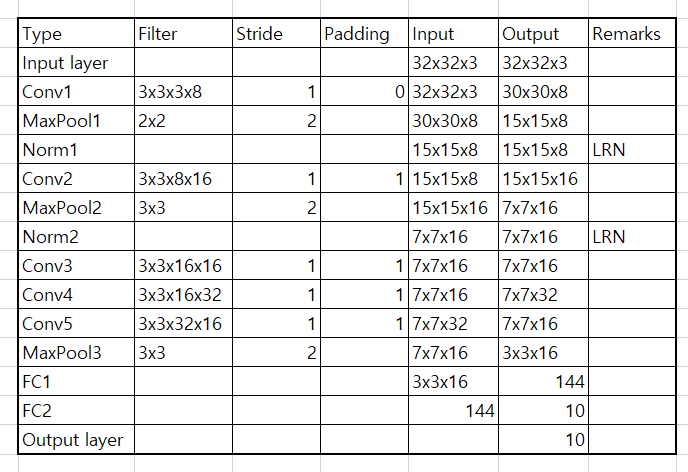

In [ ]:
parameters = {}

def initialize_parameters():
    parameters['Filter_Conv1'] = np.random.normal(loc=0.0, scale=0.01, size = (3,3,3,8))
    parameters['Filter_Conv2'] = np.random.normal(loc=0.0, scale=0.01, size = (3,3,8,16))
    parameters['Filter_Conv3'] = np.random.normal(loc=0.0, scale=0.01, size = (3,3,16,16))
    parameters['Filter_Conv4'] = np.random.normal(loc=0.0, scale=0.01, size = (3,3,16,32))
    parameters['Filter_Conv5'] = np.random.normal(loc=0.0, scale=0.01, size = (3,3,32,16))

    parameters['b_Conv1'] = 0
    parameters['b_Conv2'] = 1
    parameters['b_Conv3'] = 0
    parameters['b_Conv4'] = 1
    parameters['b_Conv5'] = 1

    parameters['W1'] = np.random.normal(loc=0.0, scale=0.01, size = (144,144))
    parameters['b1'] = 1
    parameters['W2'] = np.random.normal(loc=0.0, scale=0.01, size = (144,10))
    parameters['b2'] = 1

def forward_propagation(x):
    Conv1_Z,Conv1_A = Conv(parameters['Filter_Conv1'], parameters['b_Conv1'],1,0, x)
    LRN1,LRN1_A = LRN(Conv1_Z,2,0.0004,5,0.75)
    MaxPool1, MaxPool1_bin = MaxPool(2,2,0,LRN1)


    Conv2_Z, Conv2_A = Conv(parameters['Filter_Conv2'], parameters['b_Conv2'],1,1,MaxPool1)
    LRN2,LRN2_A = LRN(Conv2_Z,2,0.0004,5,0.75)
    MaxPool2, MaxPool2_bin = MaxPool(3,2,0,LRN2)


    Conv3_Z, Conv3_A = Conv(parameters['Filter_Conv3'],parameters['b_Conv3'],1,1,MaxPool2)
    Conv4_Z,Conv4_A = Conv(parameters['Filter_Conv4'],parameters['b_Conv4'],1,1,Conv3_Z)
    Conv5_Z, Conv5_A = Conv(parameters['Filter_Conv5'],parameters['b_Conv5'],1,1,Conv4_Z)
    MaxPool3, MaxPool3_bin = MaxPool(3,2,0,Conv5_Z)


    Flatten_input = Flatten_layer(MaxPool3)
    FC1_Z, FC1_A = FC_layer(Flatten_input,parameters['W1'] ,parameters['b1'],'relu')
    FC2_Z, FC2_A = FC_layer(FC1_A,parameters['W2'],parameters['b2'],'softmax')

    store = {}

    store['A2'] = FC2_A
    store['Z2'] = FC2_Z
    store['W2'] = parameters['W2']
    store['b2'] = parameters['b2']

    store['A1'] = FC1_A
    store['Z1'] = FC1_Z
    store['W1'] = parameters['W1']
    store['b1'] = parameters['b1']

    store['A0'] = Flatten_input

    store['A0_prev'] = MaxPool3.shape

    store['Filter_Conv5'] = parameters['Filter_Conv5']
    store['Filter_Conv4'] = parameters['Filter_Conv4']
    store['Filter_Conv3'] = parameters['Filter_Conv3']
    store['Filter_Conv2'] = parameters['Filter_Conv2']
    store['Filter_Conv1'] = parameters['Filter_Conv1']

    store['b_Conv5'] =  parameters['b_Conv5']
    store['b_Conv4'] = parameters['b_Conv4']
    store['b_Conv3'] = parameters['b_Conv3']
    store['b_Conv2'] = parameters['b_Conv2']
    store['b_Conv1'] = parameters['b_Conv1']

    store['MaxPool3_bin'] = MaxPool3_bin
    store['MaxPool2_bin'] = MaxPool2_bin
    store['MaxPool1_bin'] = MaxPool1_bin

    store['MaxPool3'] = MaxPool3
    store['MaxPool2'] = MaxPool2
    store['MaxPool1'] = MaxPool1

    store['Conv5_Z'] = Conv5_Z
    store['Conv4_Z'] = Conv4_Z
    store['Conv3_Z'] = Conv3_Z
    store['Conv2_Z'] = Conv2_Z
    store['Conv1_Z'] = Conv1_Z

    store['Conv5_A'] = Conv5_A
    store['Conv4_A'] = Conv4_A
    store['Conv3_A'] = Conv3_A
    store['Conv2_A'] = Conv2_A
    store['Conv1_A'] = Conv1_A

    store['LRN1'] = LRN1
    store['LRN1_A'] = LRN1_A
    store['LRN2'] = LRN2
    store['LRN2_A'] = LRN2_A

    return FC2_A, store

In [ ]:
print(normalized_X_train[0].shape)

initialize_parameters()
y , store = forward_propagation(normalized_X_train[0])

print(y)
print(store)

(32, 32, 3)
[[0.09381066 0.12120853 0.09270597 0.09228111 0.10258404 0.09334082
  0.10161948 0.08803276 0.08892139 0.12549524]]
{'A2': array([[0.09381066, 0.12120853, 0.09270597, 0.09228111, 0.10258404,
        0.09334082, 0.10161948, 0.08803276, 0.08892139, 0.12549524]]), 'Z2': array([[0.97364952, 1.22988347, 0.96180386, 0.95721046, 1.06305343,
        0.9686286 , 1.05360631, 0.91008001, 0.92012379, 1.26463885]]), 'W2': array([[-0.00679088,  0.00484813, -0.00411455, ..., -0.00912458,
         0.00692277, -0.00115233],
       [-0.01155553,  0.00343737, -0.00047079, ...,  0.01185202,
        -0.0042645 ,  0.00330838],
       [ 0.00941534,  0.02211134,  0.00867351, ...,  0.01125453,
        -0.0109921 ,  0.00110092],
       ...,
       [-0.01622476, -0.00602599, -0.00034406, ...,  0.00639827,
        -0.00373022, -0.00045249],
       [-0.00740953,  0.01209528,  0.00847545, ...,  0.00312476,
         0.00357719, -0.01449799],
       [-0.0121693 , -0.00561676,  0.01167011, ...,  0.00407376

In [ ]:
derevatives = {}

def backward_propagaton(img,y,t,store):

    dZ2 = y - t
    dW2 = np.dot((y - t).reshape(10,1),store['A1'].reshape(144,1).T).T
    db2 = np.sum(y-t, keepdims = True)
    dA2prev = np.dot(store['W2'],dZ2.T).T

    dZ1 = dA2prev * Relu_derivative(store['A1'])
    dW1 = np.dot(store['A0'].T, dZ1)
    db1 = np.sum(dZ1,keepdims = True)
    dA1prev = np.dot(store['W1'],dZ1.T)

    dFlatten = dA1prev.reshape(store['A0_prev'])
    dP5 = MaxPool_derivative(store['Conv5_Z'],dFlatten,store['MaxPool3_bin'])
    dC5 = dP5 * Relu_derivative(store['Conv5_Z'] - 1)

    Out_dConvK5, Out_dConvB5, Out_dConvX5 =  dConv5(dC5,store['Conv4_A'],store['Filter_Conv5'])
    dC4 = Out_dConvX5 * Relu_derivative(store['Conv4_Z'] - 1)
    Out_dConvK4, Out_dConvB4, Out_dConvX4 =  dConv4(dC4,store['Conv3_A'],store['Filter_Conv4'])
    dC3 = Out_dConvX4 * Relu_derivative(store['Conv3_Z'] - 1)
    Out_dConvK3, Out_dConvB3, Out_dConvX3 =  dConv3(Out_dConvX4,store['MaxPool2'],store['Filter_Conv3'])

    dP2 = MaxPool_derivative(store['Conv2_Z'],Out_dConvX3,store['MaxPool2_bin'])
    dLRN2 = dLRN(dP2, store['LRN2'],store['LRN2_A'])
    dC2 = dLRN2 * Relu_derivative(store['Conv2_Z'] - 1)
    Out_dConvK2, Out_dConvB2, Out_dConvX2 =  dConv2(dC2,store['MaxPool1'],store['Filter_Conv2'])

    dP1 = MaxPool_derivative(store['Conv1_Z'],Out_dConvX2,store['MaxPool1_bin'])
    dLRN1 = dLRN(dP1, store['LRN1'],store['LRN1_A'])
    dC1 = dLRN1 * Relu_derivative(store['Conv1_Z'] - 1)
    Out_dConvK1, Out_dConvB1, Out_dConvX1 =  dConv1(dC1,img,store['Filter_Conv1'])

    derevatives['W2'] = dW2
    derevatives['b2'] = db2
    derevatives['W1'] = dW1
    derevatives['b1'] = db1
    derevatives['Filter_Conv5'] = Out_dConvK5
    derevatives['b_Conv5'] = Out_dConvB5
    derevatives['Filter_Conv4'] = Out_dConvK4
    derevatives['b_Conv4'] = Out_dConvB4
    derevatives['Filter_Conv3'] = Out_dConvK3
    derevatives['b_Conv3'] = Out_dConvB3
    derevatives['Filter_Conv2'] = Out_dConvK2
    derevatives['b_Conv2'] = Out_dConvB2
    derevatives['Filter_Conv1'] = Out_dConvK1
    derevatives['b_Conv1'] = Out_dConvB1

In [ ]:
print(normalized_X_train[0].shape)

initialize_parameters()
y , store = forward_propagation(normalized_X_train[0])

pred_val = y
true_val = y_train_onehot[0]
x_img = normalized_X_train[0]

(32, 32, 3)


In [ ]:
backward_propagaton(x_img,pred_val,true_val,store)

derevatives

{'W2': array([[0.08579212, 0.09169291, 0.08594999, ..., 0.11290935, 0.09155265,
         0.08057601],
        [0.10072329, 0.10765105, 0.10090864, ..., 0.13255997, 0.10748638,
         0.09459937],
        [0.0744723 , 0.07959452, 0.07460935, ..., 0.09801156, 0.07947276,
         0.06994443],
        ...,
        [0.08275969, 0.08845192, 0.08291199, ..., 0.10891843, 0.08831661,
         0.07772795],
        [0.057426  , 0.06137577, 0.05753168, ..., 0.07557725, 0.06128188,
         0.05393454],
        [0.1088991 , 0.11638919, 0.10909949, ..., 0.14331999, 0.11621115,
         0.10227809]]),
 'b2': array([[-2.22044605e-16]]),
 'W1': array([[-0.01940728, -0.00679885,  0.01138071, ..., -0.00334302,
          0.00337854, -0.00083373],
        [-0.0212774 , -0.007454  ,  0.01247738, ..., -0.00366516,
          0.0037041 , -0.00091407],
        [-0.01984135, -0.00695092,  0.01163526, ..., -0.00341779,
          0.0034541 , -0.00085238],
        ...,
        [-0.0195612 , -0.00685277,  0.01147

## foward & backward & weight update modeling

In [ ]:
def model_train(input,target,learning_rate,epochs):
    initialize_parameters()

    for i in range(epochs):
        pred_val , store = forward_propagation(input)
        print(i,'번 째 loss : ',CE_Loss(target,pred_val))

        backward_propagaton(x_img,pred_val,target,store)

        for k in derevatives.keys():
            parameters[k] = parameters[k] - learning_rate * derevatives[k]

def model_predict(input):
    pred_val , store = forward_propagation(input)

    return np.argmax(pred_val)

In [ ]:
#train 함수 안이 아닌 밖에 dictionary 정의를 해줘야 한다 (왜인지는 모르겠음)
derevatives = {}
parameters = {}

model_train(normalized_X_train[0] ,y_train_onehot[0] ,0.05,30)
model_predict(normalized_X_train[0])

print('예측 값: ', model_predict(normalized_X_train[0]))
print('실제 값: ', np.argmax(y_train_onehot[0]))

0 번 째 loss :  1.0396280455751983
1 번 째 loss :  0.0017903871264054823
2 번 째 loss :  0.0016847907872055098
3 번 째 loss :  0.001590406751333706
4 번 째 loss :  0.0015055634932950369
5 번 째 loss :  0.001428904080392093
6 번 째 loss :  0.0013593156753787363
7 번 째 loss :  0.0012958772462794517
8 번 째 loss :  0.001237819986912031
9 번 째 loss :  0.0011844972935690847
10 번 째 loss :  0.0011353614718736425
11 번 째 loss :  0.0010899455940992279
12 번 째 loss :  0.001047849174046261
13 번 째 loss :  0.0010087268226257244
14 번 째 loss :  0.0009722791028950451
15 번 째 loss :  0.0009382440624856787
16 번 째 loss :  0.0009063951915314807
17 번 째 loss :  0.0008765319195458671
18 번 째 loss :  0.0008484772203957347
19 번 째 loss :  0.0008220743317073081
20 번 째 loss :  0.0007971839731611471
21 번 째 loss :  0.0007736819704189483
22 번 째 loss :  0.0007514572683685381
23 번 째 loss :  0.0007304102481181025
24 번 째 loss :  0.0007104513000858784
25 번 째 loss :  0.0006914996184063217
26 번 째 loss :  0.0006734821307164253
27 번 째 loss :  0.0

In [ ]:
#train 함수 안이 아닌 밖에 dictionary 정의를 해줘야 한다 (왜인지는 모르겠음)
derevatives = {}
parameters = {}

model_train(normalized_X_train[1] ,y_train_onehot[1] ,0.05,30)
model_predict(normalized_X_train[1])

print('예측 값: ', model_predict(normalized_X_train[1]))
print('실제 값: ', np.argmax(y_train_onehot[1]))

0 번 째 loss :  0.9660264109138287
1 번 째 loss :  0.0019196495180573473
2 번 째 loss :  0.001800869564701825
3 번 째 loss :  0.0016952854359264182
4 번 째 loss :  0.001600842004496115
5 번 째 loss :  0.0015158910479251577
6 번 째 loss :  0.0014390887657267722
7 번 째 loss :  0.0013693326046860168
8 번 째 loss :  0.0013057139173655301
9 번 째 loss :  0.001247468751508533
10 번 째 loss :  0.0011939540626719333
11 번 째 loss :  0.00114462531359009
12 번 째 loss :  0.0010990189863009975
13 번 째 loss :  0.001056735654924572
14 번 째 loss :  0.0010174306405931468
15 번 째 loss :  0.0009808049921029146
16 번 째 loss :  0.0009465981758468195
17 번 째 loss :  0.0009145821225569
18 번 째 loss :  0.0008845563237395051
19 번 째 loss :  0.0008563439408105828
20 번 째 loss :  0.0008297884736764239
21 번 째 loss :  0.0008047505557613666
22 번 째 loss :  0.0007811058877740666
23 번 째 loss :  0.0007587432903542325
24 번 째 loss :  0.0007375630018431995
25 번 째 loss :  0.0007174752617923241
26 번 째 loss :  0.0006983990958654211
27 번 째 loss :  0.000680

## Image Feature Extraction

학습 중간 중간 추출된 이미지의 특징들을 확인, 시각화하겠다

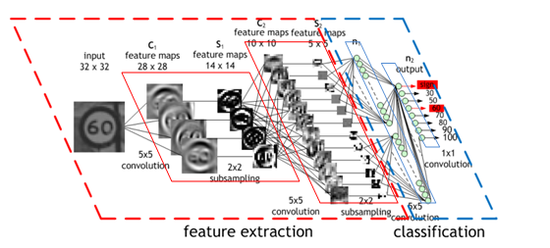

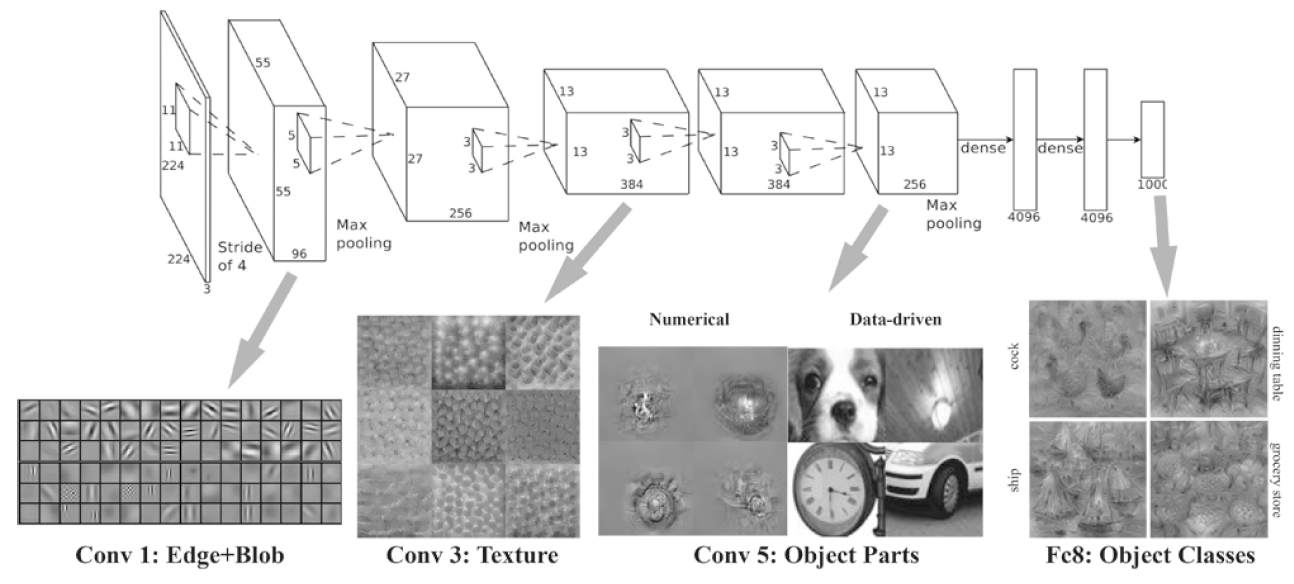

In [ ]:
for i in parameters.keys():
    print(i)

print(parameters['Filter_Conv1'].shape)
print(parameters['Filter_Conv2'].shape)
print(parameters['Filter_Conv3'].shape)
print(parameters['Filter_Conv4'].shape)
print(parameters['Filter_Conv5'].shape)

Filter_Conv1
Filter_Conv2
Filter_Conv3
Filter_Conv4
Filter_Conv5
b_Conv1
b_Conv2
b_Conv3
b_Conv4
b_Conv5
W1
b1
W2
b2
(3, 3, 3, 8)
(3, 3, 8, 16)
(3, 3, 16, 16)
(3, 3, 16, 32)
(3, 3, 32, 16)


In [ ]:
parameters['Filter_Conv1'][:,:,0,0].shape

(3, 3)

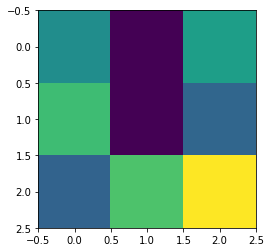

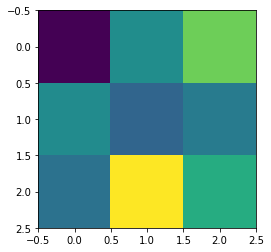

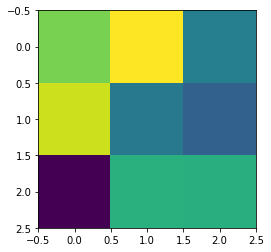

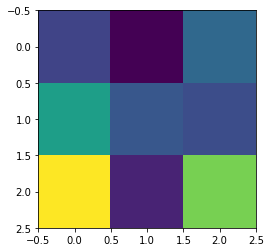

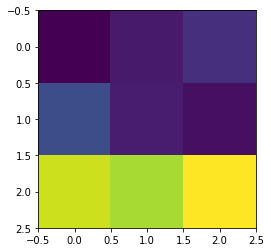

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(parameters['Filter_Conv1'][:,:,0,0])

plt.show();

plt.imshow(parameters['Filter_Conv2'][:,:,0,0])

plt.show();

plt.imshow(parameters['Filter_Conv3'][:,:,0,0])

plt.show();

plt.imshow(parameters['Filter_Conv4'][:,:,0,0])

plt.show();

plt.imshow(parameters['Filter_Conv5'][:,:,0,0])

plt.show();

In [ ]:
feature_map = {}

def forward_propagation_featureplot(x):
    Conv1_Z,Conv1_A = Conv(parameters['Filter_Conv1'], parameters['b_Conv1'],1,0, x)
    LRN1,LRN1_A = LRN(Conv1_Z,2,0.0004,5,0.75)
    MaxPool1, MaxPool1_bin = MaxPool(2,2,0,LRN1)


    Conv2_Z, Conv2_A = Conv(parameters['Filter_Conv2'], parameters['b_Conv2'],1,1,MaxPool1)
    LRN2,LRN2_A = LRN(Conv2_Z,2,0.0004,5,0.75)
    MaxPool2, MaxPool2_bin = MaxPool(3,2,0,LRN2)


    Conv3_Z, Conv3_A = Conv(parameters['Filter_Conv3'],parameters['b_Conv3'],1,1,MaxPool2)
    Conv4_Z,Conv4_A = Conv(parameters['Filter_Conv4'],parameters['b_Conv4'],1,1,Conv3_Z)
    Conv5_Z, Conv5_A = Conv(parameters['Filter_Conv5'],parameters['b_Conv5'],1,1,Conv4_Z)
    MaxPool3, MaxPool3_bin = MaxPool(3,2,0,Conv5_Z)


    Flatten_input = Flatten_layer(MaxPool3)
    FC1_Z, FC1_A = FC_layer(Flatten_input,parameters['W1'] ,parameters['b1'],'relu')
    FC2_Z, FC2_A = FC_layer(FC1_A,parameters['W2'],parameters['b2'],'softmax')

    feature_map['Conv1_Z'] = Conv1_Z
    feature_map['Conv2_Z'] = Conv2_Z
    feature_map['Conv3_Z'] = Conv3_Z
    feature_map['Conv4_Z'] = Conv4_Z
    feature_map['Conv5_Z'] = Conv5_Z

    feature_map['Conv1_A'] = Conv1_A
    feature_map['Conv2_A'] = Conv2_A
    feature_map['Conv3_A'] = Conv3_A
    feature_map['Conv4_A'] = Conv4_A
    feature_map['Conv5_A'] = Conv5_A

    feature_map['MaxPool1'] = Conv1_Z
    feature_map['MaxPool2'] = Conv2_Z
    feature_map['MaxPool3'] = MaxPool3

    return

In [ ]:
feature_map = {}

forward_propagation_featureplot(normalized_X_train[1])

In [ ]:
feature_map['Conv1_Z'].shape

(30, 30, 8)

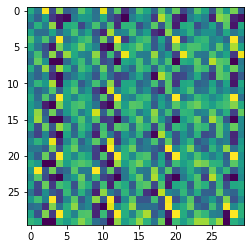

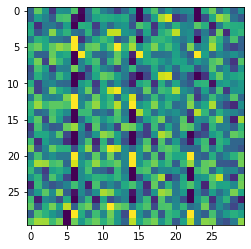

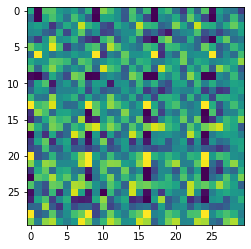

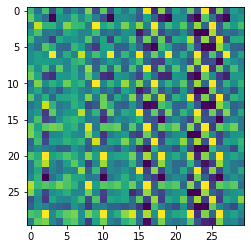

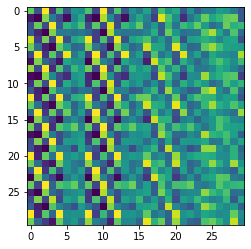

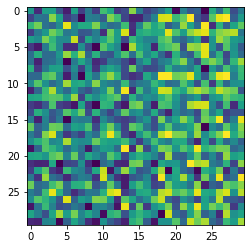

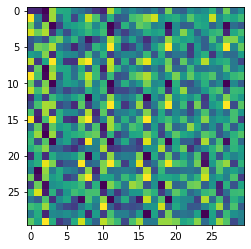

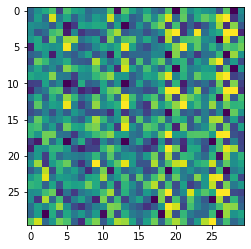

In [ ]:
for i in range(feature_map['Conv1_A'].shape[2]):
    x = feature_map['Conv1_A'][:,:,i]
    x-= x.mean()
    x/= x.std ()
    x*=  64
    x+= 128
    x= np.clip(x, 0, 255).astype('uint8')
    plt.imshow(x)
    plt.show();

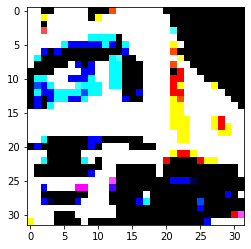

In [ ]:
plt.imshow(normalized_X_train[1])

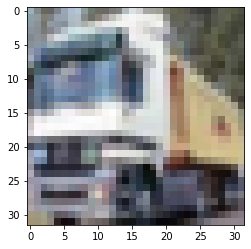

In [ ]:
plt.imshow(X_train[1])

(30, 30, 8)
Feature from Conv1


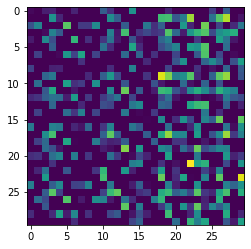

Feature from Conv2


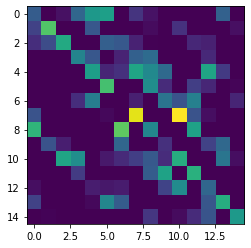

Feature from Conv3


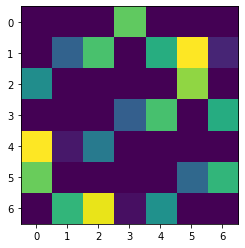

Feature from Conv4


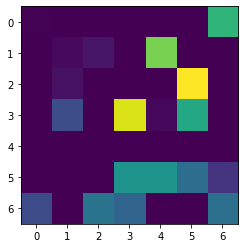

Feature from Conv5


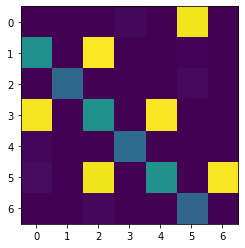

In [ ]:
model_featureplot(normalized_X_train[1])

(30, 30, 8)
Feature from Conv1


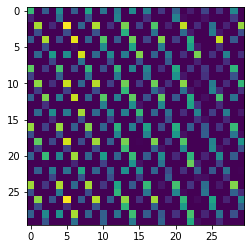

Feature from Conv2


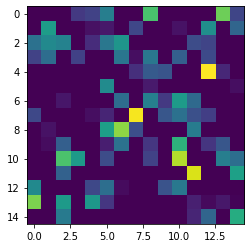

Feature from Conv3


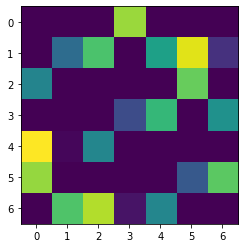

Feature from Conv4


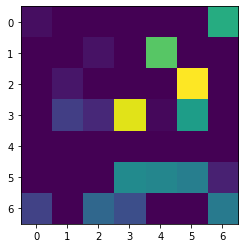

Feature from Conv5


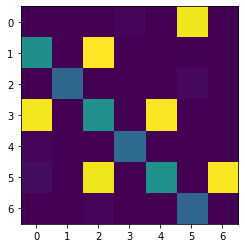

In [ ]:
model_featureplot(X_train[1])

In [ ]:
for layer_name, feature_map in zip(layer_names, feature_maps):  if len(feature_map.shape) == 4
      k = feature_map.shape[-1]
      size=feature_map.shape[1]
      for i in range(k):
        feature_image = feature_map[0, :, :, i]
        feature_image-= feature_image.mean()
        feature_image/= feature_image.std ()
        feature_image*=  64
        feature_image+= 128
        feature_image= np.clip(x, 0, 255).astype('uint8')
        image_belt[:, i * size : (i + 1) * size] = feature_image

In [ ]:
a = 'am'
b = 'is'

In [ ]:
a * b